In [1]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42 # for pdfs
matplotlib.rcParams['svg.fonttype'] = 'none' # for svgs
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from scipy import stats
from pathlib import Path

import flexiznam as flz
from cottage_analysis.analysis import spheres, common_utils
from cottage_analysis.pipelines import pipeline_utils
from v1_depth_analysis.v1_manuscript_2023 import depth_selectivity, closed_loop_rsof, get_session_list, depth_decoder
from v1_depth_analysis.v1_manuscript_2023 import common_utils as v1_common_utils
from tqdm import tqdm

In [2]:
READ_VERSION = 9
READ_ROOT = Path(
    f"/camp/lab/znamenskiyp/home/shared/presentations/v1_manuscript_2023/ver{READ_VERSION}"
)

VERSION = 9
SAVE_ROOT = Path(
    f"/camp/lab/znamenskiyp/home/shared/presentations/v1_manuscript_2023/ver{VERSION}"
)
SAVE_ROOT.mkdir(parents=True, exist_ok=True)
(SAVE_ROOT/"fig2").mkdir(parents=True, exist_ok=True)

In [3]:
# # Concatenate all sessions for openloop
# project = "hey2_3d-vision_foodres_20220101"
# flexilims_session = flz.get_flexilims_session(project)
# mouse_list = flz.get_entities("mouse", flexilims_session=flexilims_session)
# mouse_list = mouse_list[mouse_list.name.isin(["PZAH6.4b",
#                 "PZAG3.4f",
#                 "PZAH8.2h",
#                 "PZAH8.2i",
#                 "PZAH8.2f",
#                 "PZAH10.2d",
#                 "PZAH10.2f"
#                 ])]
# results_all_openloop = v1_common_utils.concatenate_all_neurons_df(
#     flexilims_session=flexilims_session,
#     session_list=get_session_list.get_sessions(
#         flexilims_session,
#         exclude_openloop=False,
#         exclude_pure_closedloop=True,
#         mouse_list=mouse_list,
#         v1_only=True,
#         trialnum_min=10,
#     ),
#     filename="neurons_df.pickle",
#     cols=[
#         "roi",
#         "best_depth",
#         "preferred_depth_closedloop",
#         "preferred_depth_closedloop_crossval",
#         "depth_tuning_popt_closedloop",
#         "depth_tuning_test_rsq_closedloop",
#         "depth_tuning_test_spearmanr_pval_closedloop",
#         "depth_tuning_test_spearmanr_rval_closedloop",
#         "preferred_RS_closedloop_g2d",
#         "preferred_RS_closedloop_crossval_g2d",
#         "preferred_OF_closedloop_g2d",
#         "preferred_OF_closedloop_crossval_g2d",
#         "rsof_rsq_closedloop_crossval_g2d",
#         "rsof_rsq_closedloop_g2d",
#         "rsof_test_rsq_closedloop_g2d",
#         "rsof_test_rsq_openloop_actual_g2d",
#         "preferred_RS_openloop_actual_g2d",
#         "preferred_OF_openloop_actual_g2d",
#         "rsof_rsq_openloop_actual_g2d",
#         "rsof_popt_closedloop_g2d",
#         "rsof_popt_openloop_actual_g2d",
#     ],
#     read_iscell=True,
#     verbose=True,
# )
# results_all_openloop["preferred_RS_closedloop_g2d"] = (
#     results_all_openloop["preferred_RS_closedloop_g2d"] * 100
# )
# results_all_openloop["preferred_depth_closedloop"] = (
#     results_all_openloop["preferred_depth_closedloop"] * 100
# )
# results_all_openloop["preferred_OF_closedloop_g2d"] = np.degrees(
#     results_all_openloop["preferred_OF_closedloop_g2d"]
# )
# results_all_openloop["preferred_RS_openloop_actual_g2d"] = (
#     results_all_openloop["preferred_RS_openloop_actual_g2d"] * 100
# )
# results_all_openloop["preferred_OF_openloop_actual_g2d"] = np.degrees(
#     results_all_openloop["preferred_OF_openloop_actual_g2d"]
# )

# results_all_openloop.to_pickle(SAVE_ROOT / "fig2" / "results_all_rsof_openloop_rsq.pickle")
results_all_openloop = pd.read_pickle(SAVE_ROOT / "fig2" / "results_all_rsof_openloop.pickle")

In [4]:
results_all_openloop["amplitude_closedloop"] = results_all_openloop["rsof_popt_closedloop_g2d"].apply(
    lambda x: np.exp(x[0]) + x[-1]
)
results_all_openloop["amplitude_openloop"] = results_all_openloop["rsof_popt_openloop_actual_g2d"].apply(
    lambda x: np.exp(x[0]) + x[-1]
)

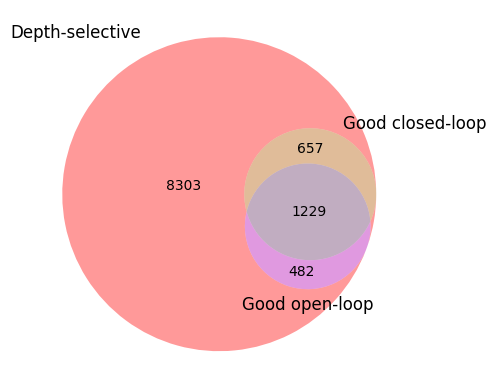

In [5]:
# venn diagram on all depth-selective neurons, neurons with good closedloop rsq and with good openloop rsq
rsq_threshold = 0.02
iscell = (results_all_openloop["iscell"]==1)
depth_selective = (
    (results_all_openloop["depth_tuning_test_spearmanr_pval_closedloop"] < 0.05)
    & (results_all_openloop["depth_tuning_test_spearmanr_rval_closedloop"] > 0.1)
)
good_closedloop_fit = ((results_all_openloop["rsof_test_rsq_closedloop_g2d"] > rsq_threshold))
good_openloop_fit = ((results_all_openloop["rsof_test_rsq_openloop_actual_g2d"] > rsq_threshold))

depth_selective_neurons = results_all_openloop[
    iscell & depth_selective
]
good_closedloop = results_all_openloop[
    iscell & depth_selective & good_closedloop_fit
]
good_openloop = results_all_openloop[
    iscell & depth_selective & good_openloop_fit
]
good_both = results_all_openloop[
    iscell & depth_selective & good_closedloop_fit & good_openloop_fit
]

good_either = results_all_openloop[
    iscell & depth_selective & (good_closedloop_fit | good_openloop_fit)
]

from matplotlib_venn import venn3
venn3(
    [set(depth_selective_neurons.index.values),
        set(good_closedloop.index.values),
        set(good_openloop.index.values)],
    set_labels=("Depth-selective", "Good closed-loop", "Good open-loop"),
)

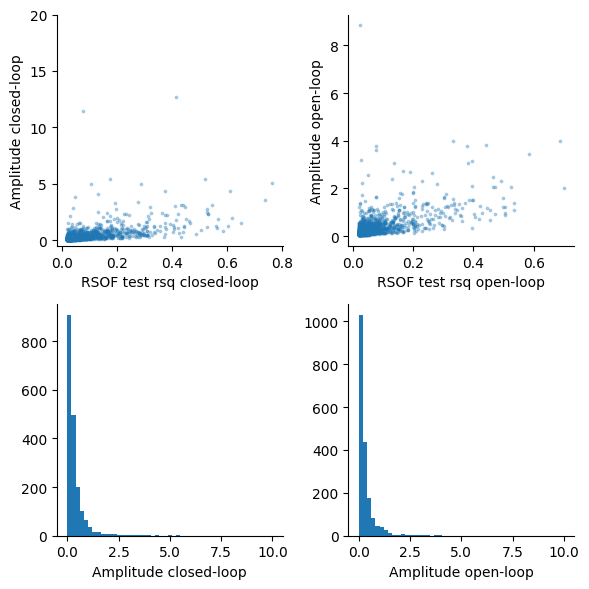

In [9]:
# histogram of amplitude for good closed-loop and open-loop neurons
plt.figure(figsize=(6, 6))
plt.subplot(2, 2, 1)
plt.scatter(good_closedloop["rsof_test_rsq_closedloop_g2d"].values, good_closedloop["amplitude_closedloop"].values,
            s = 3, alpha = 0.3)
plt.ylim([-0.5,20])
plt.xlabel("RSOF test rsq closed-loop")
plt.ylabel("Amplitude closed-loop")
sns.despine()
plt.subplot(2, 2, 2)
plt.scatter(good_openloop["rsof_test_rsq_openloop_actual_g2d"].values, good_openloop["amplitude_openloop"].values,
            s = 3, alpha = 0.3)
plt.xlabel("RSOF test rsq open-loop")
plt.ylabel("Amplitude open-loop")
sns.despine()
plt.subplot(2, 2, 3)
bins = np.linspace(0, 10, 50)
plt.hist(good_closedloop["amplitude_closedloop"].values, bins = bins);
plt.xlabel("Amplitude closed-loop")
sns.despine()
plt.subplot(2, 2, 4)
bins = np.linspace(0, 10, 50)
plt.hist(good_closedloop["amplitude_openloop"].values, bins = bins);
plt.xlabel("Amplitude open-loop")
sns.despine()
plt.tight_layout()

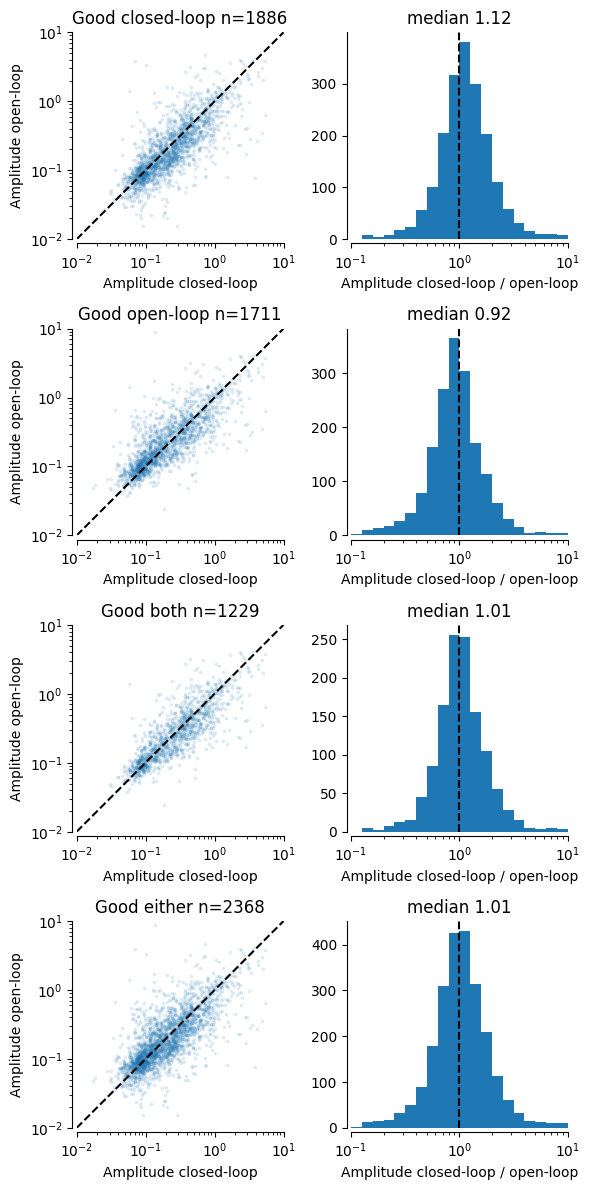

In [10]:
# amplitude closed loop vs open loop
plt.figure(figsize=(6, 12))
for idata, (data, title) in enumerate(zip([good_closedloop, good_openloop, good_both, good_either],
                                          ["Good closed-loop", "Good open-loop", "Good both", "Good either"])):
    plt.subplot2grid((4, 2), (idata, 0))
    plt.scatter(data["amplitude_closedloop"].values, data["amplitude_openloop"].values,
                s = 3, alpha = 0.1)
    plt.xlabel("Amplitude closed-loop")
    plt.ylabel("Amplitude open-loop")
    plt.xlim([0.01, 10])
    plt.ylim([0.01, 10])
    plt.plot([0.01, 10], [0.01, 10], "k--")
    plt.xscale("log")
    plt.yscale("log")
    plt.title(f"{title} n={len(data)}")
    sns.despine(ax=plt.gca(), offset = 3)
    plt.gca().set_aspect('equal', adjustable='box')
    
    plt.subplot2grid((4, 2), (idata, 1))
    bins = np.geomspace(0.1, 10, 21)
    plt.hist(data["amplitude_closedloop"].values / data["amplitude_openloop"].values, bins = bins);
    plt.xlabel("Amplitude closed-loop / open-loop")
    plt.xscale("log")
    plt.xlim([0.1, 10])
    plt.axvline(1, color = "k", linestyle = "--")
    sns.despine(ax=plt.gca(), offset = 3)
    plt.title(f"median {np.median(data['amplitude_closedloop'].values / data['amplitude_openloop'].values):.2f}")
plt.tight_layout()

/tmp/ipykernel_107644/3650602463.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["mouse"] = data["session"].str.split("_").str[0]
100%|██████████| 1000/1000 [00:29<00:00, 34.04it/s]


p val:0.902


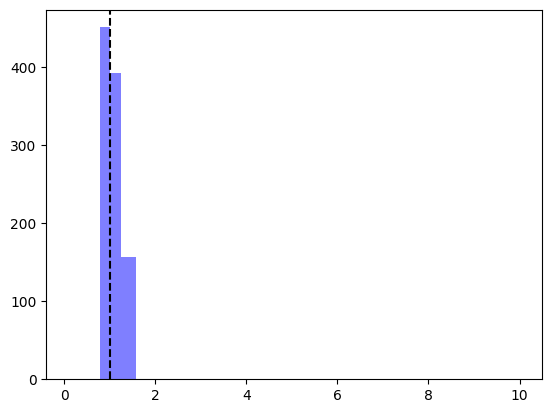

In [8]:
from scipy import stats
def hierarchical_bootstrap_stats(data, n_boots, xcol, resample_cols, ycol=None, correlation=False, do_ratio=False):
    if "mouse" not in data.columns:
        data["mouse"] = data["session"].str.split("_").str[0]
    ratio_dist = None
    if ycol is None:
        distribution = np.zeros(n_boots)
    else:
        distribution = np.zeros((n_boots, len(ycol)))
        if do_ratio:
            ratio_dist = np.zeros((n_boots, len(ycol)))
    if correlation:
        r = stats.spearmanr(data[xcol], data[ycol])[0]
    else:
        r = None
    for i in tqdm(range(n_boots)):
        sample = common_utils.bootstrap_sample(data, resample_cols)
        if ycol is None:
            distribution[i] = np.median(data.loc[sample][xcol])
        else:
            if correlation:
                for j, (x, y) in enumerate(zip(xcol, ycol)):
                    distribution[i, j] = stats.spearmanr(data.loc[sample][x], data.loc[sample][y])[0]
                    ratio_dist[i, j] = np.median(data.loc[sample][x]/data.loc[sample][y])
    plt.hist(ratio_dist, bins = np.geomspace(0.1, 10, 21), alpha = 0.5, color = "b");
    plt.axvline(1, color = "k", linestyle = "--")
    print(f"p val:{np.min([np.mean(ratio_dist<1), np.mean(ratio_dist>1)])*2}")
    return r, distribution, ratio_dist

r, distribution, ratio_dist = hierarchical_bootstrap_stats(data=good_either, 
                                               n_boots=1000, 
                                               xcol=["amplitude_closedloop"], 
                                               resample_cols=["mouse", "session"], 
                                               ycol=["amplitude_openloop"], 
                                               correlation=True,
                                               do_ratio=True)
